### Sentimental_analysis

#### 1. 데이터 읽어오기

In [3]:
import numpy as np
import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [6]:
df_train = pd.read_csv('C://Users//mark//Desktop//data//train.txt', header =None, sep =';', names = ['Sentence','Emotion'], encoding='utf-8')
df_test = pd.read_csv('C://Users//mark//Desktop//data//test.txt', header = None, sep =';', names = ['Sentence','Emotion'],encoding='utf-8')
df_val=pd.read_csv('C://Users//mark//Desktop//data//val.txt',header=None,sep=';',names=['Sentence','Emotion'],encoding='utf-8')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  16000 non-null  object
 1   Emotion   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


#### 2. train_set 데이터 분포와 특징 확인

In [8]:
df_train['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

<BarContainer object of 6 artists>

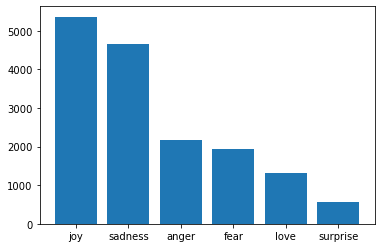

In [9]:
# 막대 그래프 그려 확인하기
# 전체 값의 10%의 적은 비중을 차지하는 surprise 같은 경우 불균형 데이터라고 여겨질 수 있어 눈여겨 보아야 한다. 
value=df_train['Emotion'].value_counts()
plt.bar(value.index, value.values)

#### 3. wordcloud로 분포 확인하기
##### 빈도수가 높은 단어를 출력하여 시각화한다.

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

In [15]:
# 공백 문자 기준 잘라 소문자로 모두 변환하여 리스트 형식으로 담는다.
tokens = re.findall("[\w']+", df_train['Sentence'].str.lower().str.cat(sep=' ')) 

In [16]:
# nltk의 stopwords를 가져와 tokens 변수에서 stopwords에 해당되지 않는 단어를 걸러 filtered_sentence에 저장한다.
nltk.download('stopwords')
en_stops = set(stopwords.words('english'))

filtered_sentence = []
filtered_sentence=[word for word in tokens if word not in en_stops]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mark\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


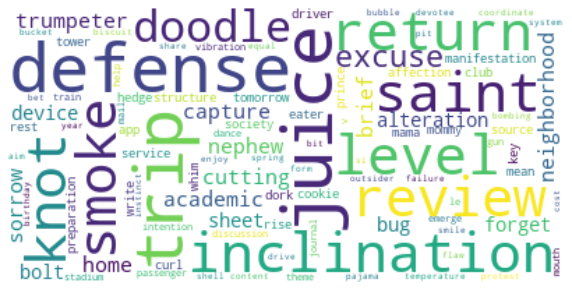

In [18]:
text = list(set(filtered_sentence)) # 중복 제거

# 전체데이터의 wordcloud 출력
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="white").generate(' '.join(text))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
# 하나의 감정분류(sadness, anger, etc.)의 wordcloud를 보고 싶다면 아래와 전처리하고 filtered_sentence에 담아 출력한다.

In [ ]:
# fear에 해당하는 데이터만 갖고 오기
tokens = re.findall("[\w']+", df_train[df_train['Emotion']=='fear']['Sentence'].str.lower().str.cat(sep=' '))
filtered_sentence = [token for token in tokens if not token in en_stops]
filtered_sentence

#### 4. validation_set과 test_set data도 확인

In [21]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2000 non-null   object
 1   Emotion   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2000 non-null   object
 1   Emotion   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


#### 5. 단어의 토큰화

In [23]:
# 단어 혹은 글자 단위로 토큰화(tokenize)
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mark\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [ ]:
token_sentence = []
for sentence in df_train['Sentence']:
    token_sentence.append(word_tokenize(sentence))
print(token_sentence)

df_train['token_sentence'] = token_sentence
df_train

#### 6. stop_words 제거

In [25]:
filtered_sentence = []
stop_words = set(stopwords.words('english'))

for sentence in df_train['token_sentence']:
    word_token=[word for word in sentence if word not in stop_words]
    filtered_sentence.append(word_token)
print(len(filtered_sentence))

16000


#### 7. 표준화(Stemming) 
#### 감성 분석의 경우 시제(과거-현재-미래)에 구분 없이 뜻에 포커스 할 수 있도록 표준화하는 작업이 필요하다.

In [26]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [27]:
stemming_sentence = []
for sentence in filtered_sentence:
    word_token = [stemmer.stem(word) for word in sentence]
    stemming_sentence.append(word_token)

#### 8. Bag of words(BOW) 만들기

In [28]:
from  keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(stemming_sentence)

In [ ]:
print(len(tokenizer.word_index)) # 10,376 rows
tokenizer.word_index 

#### 9. Padding
#### 토큰을 인덱스 값으로 변환

In [ ]:
# sequence로 변경
# 문장의 길이가 모두 다르지만 딥러닝은 입력값을 고정값으로 받기 때문에 padding으로 최대 길이에 맞게 맞춰준다.
X_train=tokenizer.texts_to_sequences(stemming_sentence)
X_train

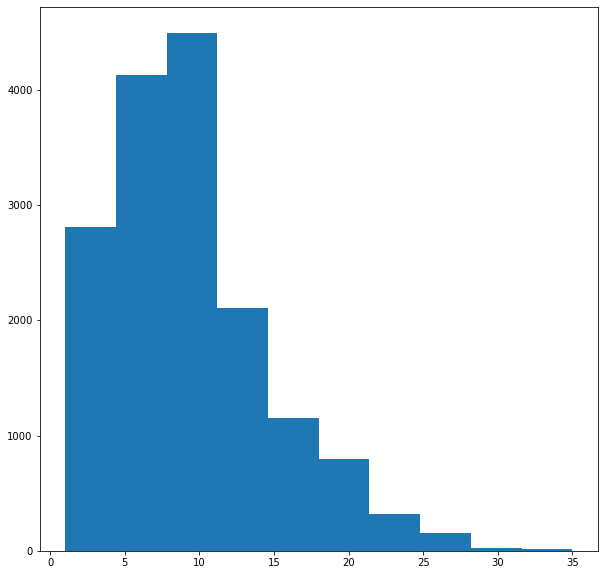

In [31]:
# 문장 길이 분포를 그래프로 확인하기
import matplotlib.pyplot as plt

num_token_per_sentence = [ len(sentence) for sentence in X_train ]
# print(max(num_token_per_sentence))
plt.hist(num_token_per_sentence)
plt.show()

In [32]:
# pad_sequences를 사용하여 X_train 길이 통일하기
X_train_pad=pad_sequences(X_train)
X_train_pad

array([[   0,    0,    0, ...,   59,    2,  581],
       [   0,    0,    0, ...,   67,   95, 1112],
       [   0,    0,    0, ...,    2,  421,  178],
       ...,
       [   0,    0,    0, ...,  256,   38, 1172],
       [   0,    0,    0, ...,  470,    4,  265],
       [   0,    0,    0, ...,    2,  201, 1655]])

#### 10. Label 데이터 변환

#### `'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5` 방식으로 맵핑, 변환한다.

In [33]:
df_train['Emotion']=df_train['Emotion'].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_train['Emotion']
y_train = np.array(df_train['Emotion'].values)
y_train

array([3, 3, 1, ..., 0, 1, 3], dtype=int64)

#### 11. validation, test dataset 데이터도 동일하기 전처리

In [34]:
stemming_sentence_val = []
stemming_sentence_test = []

for sentence in df_val['Sentence']:
    word_token=word_tokenize(sentence)
    word_token=[stemmer.stem(word) for word in word_token]
    stemming_sentence_val.append(word_token)
    
for sentence in df_test['Sentence']:
    word_token=word_tokenize(sentence)
    word_token=[stemmer.stem(word) for word in word_token]
    stemming_sentence_test.append(word_token)
 
X_val=tokenizer.texts_to_sequences(stemming_sentence_val)
X_test=tokenizer.texts_to_sequences(stemming_sentence_test)

X_val_pad=pad_sequences(X_val)
X_test_pad=pad_sequences(X_test)

df_val['Emotion']=df_val['Emotion'].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Emotion']=df_test['Emotion'].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

y_val = np.array(df_val['Emotion'].values)
y_test = np.array(df_test['Emotion'].values)

#### 12. 딥러닝 모델 설정
#### 감성 분류를 위해 LSTM을 사용한다.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

In [36]:
sequence_length = 35 # max(num_token_per_sentence)
vocabulary_size = len(tokenizer.word_index)+1 # 10376
embedding_dim = 256

In [37]:
model = Sequential([
    Embedding(vocabulary_size, embedding_dim),
    LSTM(units=50, input_shape=(vocabulary_size, embedding_dim), return_sequences=True),
    LSTM(units=25),
    Dense(20, activation="relu"),
    Dropout(0.05),
    Dense(6, activation = "softmax")
    ])

# model compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

#### 13. 학습
##### `epoch = 10, batch_size = 64`

In [38]:
history=model.fit(X_train_pad, y_train, batch_size=64, epochs=10, validation_data=(X_val_pad, y_val))

Epoch 1/10
250/250 [==============================] - 21s 71ms/step - loss: 1.5622 - accuracy: 0.3740 - val_loss: 0.9290 - val_accuracy: 0.6685
Epoch 2/10
250/250 [==============================] - 17s 70ms/step - loss: 0.6298 - accuracy: 0.7893 - val_loss: 0.4929 - val_accuracy: 0.8320
Epoch 3/10
250/250 [==============================] - 18s 71ms/step - loss: 0.2484 - accuracy: 0.9190 - val_loss: 0.4203 - val_accuracy: 0.8715
Epoch 4/10
250/250 [==============================] - 19s 77ms/step - loss: 0.1368 - accuracy: 0.9591 - val_loss: 0.5096 - val_accuracy: 0.8465
Epoch 5/10
250/250 [==============================] - 20s 78ms/step - loss: 0.0897 - accuracy: 0.9708 - val_loss: 0.4630 - val_accuracy: 0.8700
Epoch 6/10
250/250 [==============================] - 19s 77ms/step - loss: 0.0647 - accuracy: 0.9772 - val_loss: 0.6587 - val_accuracy: 0.8300
Epoch 7/10
250/250 [==============================] - 17s 68ms/step - loss: 0.0533 - accuracy: 0.9816 - val_loss: 0.6185 - val_accuracy:

#### 14. 평가 및 예측

In [39]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print('test set accuracy: ', test_accuracy)

63/63 [==============================] - 1s 10ms/step - loss: 0.8077 - accuracy: 0.8440
test set accuracy:  0.843999981880188


In [40]:
test_prediction =model.predict(X_test_pad)
test_prediction

array([[1.27113381e-05, 8.99184579e-06, 1.92529824e-05, 9.99952078e-01,
        6.04751767e-06, 8.20680157e-07],
       [2.16118115e-05, 3.81848404e-05, 2.10104663e-05, 9.99879718e-01,
        3.81195314e-05, 1.30641035e-06],
       [6.78310971e-06, 1.23811078e-05, 1.47380815e-05, 9.99959469e-01,
        5.98730639e-06, 7.57658313e-07],
       ...,
       [9.99795377e-01, 5.15607439e-07, 1.82920092e-04, 1.32779351e-05,
        7.67495294e-06, 3.13050123e-07],
       [7.61973739e-01, 7.80861683e-06, 2.37524047e-01, 3.64705746e-04,
        3.17588783e-05, 9.78783573e-05],
       [5.14325860e-04, 4.34527086e-04, 5.64036134e-04, 1.24623522e-03,
        1.32598693e-03, 9.95914876e-01]], dtype=float32)

In [41]:
for i in range(5): 
    test_prediction
    print("{} 번째 테스트 데이터 문장: \n{}".format(i, df_test['Sentence'][i]))
    print("{} 번째 테스트 데이터의 예측 결과: {}, 실제 데이터: {}\n".format(i, test_prediction[i], df_test['Emotion'][i]))

0 번째 테스트 데이터 문장: 
im feeling rather rotten so im not very ambitious right now
0 번째 테스트 데이터의 예측 결과: [1.2711338e-05 8.9918458e-06 1.9252982e-05 9.9995208e-01 6.0475177e-06
 8.2068016e-07], 실제 데이터: 3

1 번째 테스트 데이터 문장: 
im updating my blog because i feel shitty
1 번째 테스트 데이터의 예측 결과: [2.1611811e-05 3.8184840e-05 2.1010466e-05 9.9987972e-01 3.8119531e-05
 1.3064104e-06], 실제 데이터: 3

2 번째 테스트 데이터 문장: 
i never make her separate from me because i don t ever want her to feel like i m ashamed with her
2 번째 테스트 데이터의 예측 결과: [6.78310971e-06 1.23811078e-05 1.47380815e-05 9.99959469e-01
 5.98730639e-06 7.57658313e-07], 실제 데이터: 3

3 번째 테스트 데이터 문장: 
i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
3 번째 테스트 데이터의 예측 결과: [9.9970323e-01 6.6060016e-07 2.5867074e-04 3.0016989e-05 7.0806896e-06
 2.8170101e-07], 실제 데이터: 0

4 번째 테스트 데이터 문장: 
i was feeling a little vain when i did this one
4 번째 테스트 데이터의 예측 결과: [7.9635811e-06 1.2124220e-05 1.5125949e-0